### **Data Preprocessing**


In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token

train_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="validation[:10%]")

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/0128610a44e10f25b4af6689441c72af86205282d26399642f7db38fa7535602. Subsequent calls will reuse this data.


In [ ]:
batch_size=4  # change to 16 for full training
encoder_max_length=512
decoder_max_length=128

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer(batch["highlights"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["decoder_attention_mask"] = outputs.attention_mask
  batch["labels"] = outputs.input_ids.copy()

  # because BERT automatically shifts the labels, the labels correspond exactly to `decoder_input_ids`.
  # We have to make sure that the PAD token is ignored
  batch["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch["labels"]]

  return batch

# only use 32 training examples for notebook - DELETE LINE FOR FULL TRAINING
train_data = train_data.select(range(32))

train_data = train_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)


# only use 16 training examples for notebook - DELETE LINE FOR FULL TRAINING
val_data = val_data.select(range(16))

val_data = val_data.map(
    process_data_to_model_inputs,
    batched=True,
    batch_size=batch_size,
    remove_columns=["article", "highlights", "id"]
)
val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

### **Warm-starting the Encoder-Decoder Model**

In [ ]:
from transformers import EncoderDecoderModel

bert2bert = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

In [ ]:
# set special tokens
bert2bert.config.decoder_start_token_id = tokenizer.bos_token_id
bert2bert.config.eos_token_id = tokenizer.eos_token_id
bert2bert.config.pad_token_id = tokenizer.pad_token_id

# sensible parameters for beam search
bert2bert.config.vocab_size = bert2bert.config.decoder.vocab_size
bert2bert.config.max_length = 142
bert2bert.config.min_length = 56
bert2bert.config.no_repeat_ngram_size = 3
bert2bert.config.early_stopping = True
bert2bert.config.length_penalty = 2.0
bert2bert.config.num_beams = 4

### **Fine-Tuning Warm-Started Encoder-Decoder Models**

The `Seq2SeqTrainer` that can be found under [examples/seq2seq/seq2seq_trainer.py](https://github.com/huggingface/transformers/blob/master/examples/seq2seq/seq2seq_trainer.py) will be used to fine-tune a warm-started encoder-decoder model.

Let's download the `Seq2SeqTrainer` code and import the module along with `TrainingArguments`.

In [ ]:
%%capture
!rm seq2seq_trainer.py
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/seq2seq/seq2seq_trainer.py

!pip install git-python==1.0.3
!pip install sacrebleu==1.4.12
!pip install rouge_score

from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

We need to add some additional parameters to make `TrainingArguments` compatible with the `Seq2SeqTrainer`. Let's just copy the `dataclass` arguments as defined in [this file](https://github.com/patrickvonplaten/transformers/blob/make_seq2seq_trainer_self_contained/examples/seq2seq/finetune_trainer.py).

In [ ]:
@dataclass
class Seq2SeqTrainingArguments(TrainingArguments):
    label_smoothing: Optional[float] = field(
        default=0.0, metadata={"help": "The label smoothing epsilon to apply (if not zero)."}
    )
    sortish_sampler: bool = field(default=False, metadata={"help": "Whether to SortishSamler or not."})
    predict_with_generate: bool = field(
        default=False, metadata={"help": "Whether to use generate to calculate generative metrics (ROUGE, BLEU)."}
    )
    adafactor: bool = field(default=False, metadata={"help": "whether to use adafactor"})
    encoder_layerdrop: Optional[float] = field(
        default=None, metadata={"help": "Encoder layer dropout probability. Goes into model.config."}
    )
    decoder_layerdrop: Optional[float] = field(
        default=None, metadata={"help": "Decoder layer dropout probability. Goes into model.config."}
    )
    dropout: Optional[float] = field(default=None, metadata={"help": "Dropout probability. Goes into model.config."})
    attention_dropout: Optional[float] = field(
        default=None, metadata={"help": "Attention dropout probability. Goes into model.config."}
    )
    lr_scheduler: Optional[str] = field(
        default="linear", metadata={"help": f"Which lr scheduler to use."}
    )

Also, we need to define a function to correctly compute the ROUGE score during validation. ROUGE is a much better metric to track during training than only language modeling loss.

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

Cool! Finally, we start training.

In [ ]:
# set training arguments - these params are not really tuned, feel free to change
training_args = Seq2SeqTrainingArguments(
    output_dir="./",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    predict_with_generate=True,
    evaluate_during_training=True,
    do_train=True,
    do_eval=True,
    logging_steps=2,  # set to 1000 for full training
    save_steps=16,  # set to 500 for full training
    eval_steps=4,  # set to 8000 for full training
    warmup_steps=1,  # set to 2000 for full training
    max_steps=16, # delete for full training
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True,
)

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bert2bert,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

/usr/local/lib/python3.6/dist-packages/transformers/training_args.py:339: FutureWarning: The `evaluate_during_training` argument is deprecated in favor of `evaluation_strategy` (which has more options)
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/datasets/arrow_dataset.py:835: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.tensor(x, **format_kwargs)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposi

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
4,10.039099,10.122349,0.000000,0.000000,0.000000
8,7.995964,7.960626,0.001800,0.002300,0.002000
12,7.675583,7.756617,0.005500,0.015100,0.008000
16,7.481323,7.709305,0.004800,0.013600,0.007000


TrainOutput(global_step=16, training_loss=8.646506309509277)

### **Evaluation**


In [ ]:
import datasets
from transformers import BertTokenizer, EncoderDecoderModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = EncoderDecoderModel.from_pretrained("./checkpoint-16")
model.to("cuda")

test_data = datasets.load_dataset("cnn_dailymail", "3.0.0", split="test")

# only use 16 training examples for notebook - DELETE LINE FOR FULL TRAINING
test_data = test_data.select(range(16))

batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer(batch["article"], padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["article"])

pred_str = results["pred"]
label_str = results["highlights"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

print(rouge_output)


Score(precision=0.005856995548236219, recall=0.020109209844549343, fmeasure=0.00887036509937936)


### **Comparison**

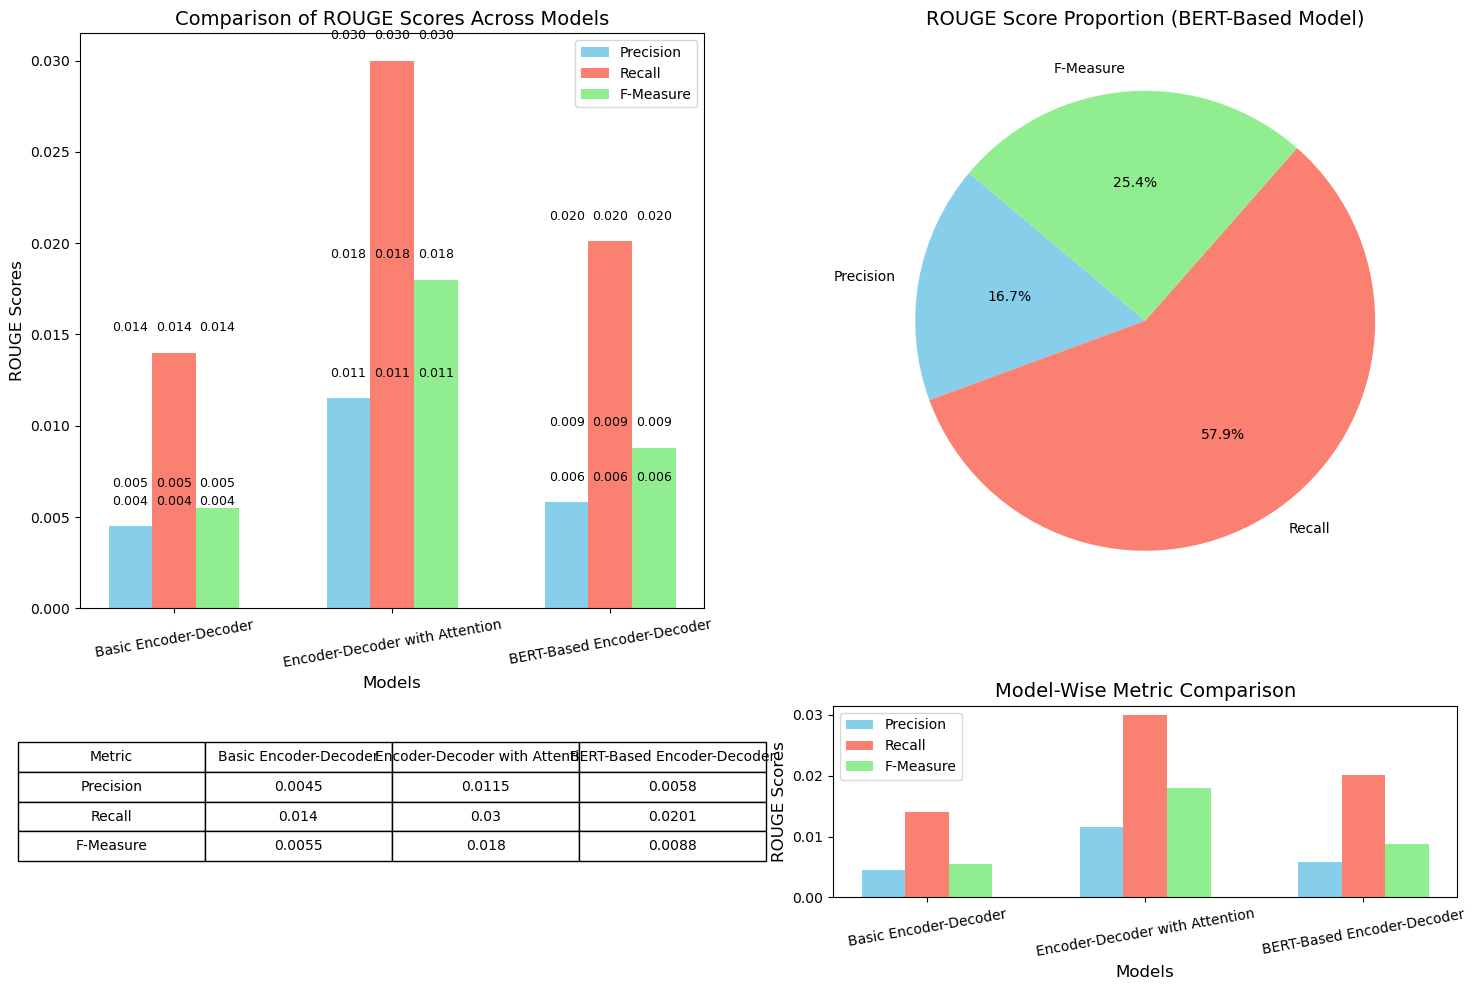

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ["Basic Encoder-Decoder", "Encoder-Decoder with Attention", "BERT-Based Encoder-Decoder"]
precision = [0.0045, 0.0115, 0.0058]  # Example precision values
recall = [0.014, 0.030, 0.0201]       # Example recall values
fmeasure = [0.0055, 0.018, 0.0088]    # Example F-measure values

# Create the plot layout with 4 rows (1 for the table and 3 for charts)
fig, axs = plt.subplots(4, 1, figsize=(10, 15), gridspec_kw={'height_ratios': [1, 3, 3, 3]})
plt.subplots_adjust(hspace=0.4)

### 1. Table
table_data = [
    ["Precision", *precision],
    ["Recall", *recall],
    ["F-Measure", *fmeasure],
]
table = axs[0].table(
    cellText=table_data,
    colLabels=["Metric"] + models,
    loc="center",
    cellLoc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axs[0].axis("off")

### 2. Bar Chart with Scores Comparison
bar_width = 0.2
x = np.arange(len(models))

# Bar chart
axs[1].bar(x - bar_width, precision, width=bar_width, label="Precision", color="skyblue")
axs[1].bar(x, recall, width=bar_width, label="Recall", color="salmon")
axs[1].bar(x + bar_width, fmeasure, width=bar_width, label="F-Measure", color="lightgreen")

# Labels and title
axs[1].set_xlabel("Models", fontsize=12)
axs[1].set_ylabel("ROUGE Scores", fontsize=12)
axs[1].set_title("Comparison of ROUGE Scores Across Models", fontsize=14)
axs[1].set_xticks(x)
axs[1].set_xticklabels(models, rotation=10, fontsize=10)
axs[1].legend()

# Add data labels
for bar_group in [precision, recall, fmeasure]:
    for bar, value in zip(axs[1].patches, bar_group * 3):
        axs[1].text(
            bar.get_x() + bar.get_width() / 2, 
            value + 0.001, 
            f"{value:.3f}", 
            ha="center", va="bottom", fontsize=9
        )

### 3. Pie Chart for BERT-Based Model
bert_scores = [precision[2], recall[2], fmeasure[2]]
labels = ["Precision", "Recall", "F-Measure"]
colors = ["skyblue", "salmon", "lightgreen"]

axs[2].pie(
    bert_scores, labels=labels, autopct="%1.1f%%", startangle=140, colors=colors
)
axs[2].set_title("ROUGE Score Proportion (BERT-Based Model)", fontsize=14)

### 4. Grouped Bar Chart for Each Metric
metrics = ["Precision", "Recall", "F-Measure"]
metric_scores = [precision, recall, fmeasure]
metric_colors = ["skyblue", "salmon", "lightgreen"]

for i, (metric, color, scores) in enumerate(zip(metrics, metric_colors, metric_scores)):
    axs[3].bar(x + i * bar_width - bar_width, scores, width=bar_width, label=metric, color=color)

axs[3].set_xlabel("Models", fontsize=12)
axs[3].set_ylabel("ROUGE Scores", fontsize=12)
axs[3].set_title("Model-Wise Metric Comparison", fontsize=14)
axs[3].set_xticks(x)
axs[3].set_xticklabels(models, rotation=10, fontsize=10)
axs[3].legend()

# Show Plot
plt.tight_layout()
plt.show()

